In [1]:
from utils import load_crypto_dir, preprocess_ohlc, align_two
from trade import Exchange, CointBacktester
from plot import (
    plot_equity_with_trades,
    plot_trade_residual_paths,
    plot_trade_linear_spread_paths,
    heatmap_from_pivot,
    heatmap_from_pivot_mask_nan,
)
from metrics import summarize_performance, summarize_close_reasons, equity_to_returns
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = "/home/jim/cfem_project/data/futures"
start_date = "2022-11-01"
end_date = "2024-12-31"

df_dict = load_crypto_dir(data_dir, start_date=start_date, end_date=end_date)
sorted(df_dict.keys())

['1INCHUSDT_1d',
 '1INCHUSDT_1h',
 'BANDUSDT_1d',
 'BANDUSDT_1h',
 'C98USDT_1d',
 'C98USDT_1h',
 'CELOUSDT_1d',
 'CELOUSDT_1h',
 'DOGEUSDT_1d',
 'DOGEUSDT_1h',
 'DOTUSDT_1d',
 'DOTUSDT_1h',
 'KSMUSDT_1d',
 'KSMUSDT_1h',
 'MINAUSDT_1d',
 'MINAUSDT_1h',
 'OPUSDT_1d',
 'OPUSDT_1h']

In [3]:
key1 = "KSMUSDT_1h"
key2 = "CELOUSDT_1h"

df1 = preprocess_ohlc(df_dict[key1])
df2 = preprocess_ohlc(df_dict[key2])

coint_var = "log_close"
merged_df = align_two(df1, df2, coint_var=coint_var)
merged_df.head()

open_time  log_close_1  close_1  log_close_2  close_2
0 2022-11-01 00:00:00     3.549617    34.80    -0.291690    0.747
1 2022-11-01 01:00:00     3.552773    34.91    -0.286350    0.751
2 2022-11-01 02:00:00     3.552200    34.89    -0.281038    0.755
3 2022-11-01 03:00:00     3.547316    34.72    -0.278392    0.757
4 2022-11-01 04:00:00     3.542986    34.57    -0.298406    0.742

In [4]:
ex = Exchange(merged_df, coint_var=coint_var)

start = merged_df["open_time"].min()
end = merged_df["open_time"].max()

bt = CointBacktester(
    exchange=ex,
    start_time=start,
    end_time=end,
    coint_var=coint_var,
    train_len=60 * 24,  # window length in bars
    gap=24,  # decision cadence in bars
    pval_alpha=0.05,
    entry_k=2.0,
    exit_k=0.5,
    relaxed_pval_alpha=0.20,     # optional
    stop_k=3.5,                  # optional
    initial_balance=1_000_000.0,
    trade_frac=0.05,
    margin_rate=0.10,
)

daily, fits = bt.run()
fits.head()

fit_time     beta0  beta1_log  sigma_log   p_value  entry_allowed  \
0 2022-12-31  3.719929   0.672958   0.053288  0.020545           True   
1 2023-01-01  3.718138   0.671957   0.053559  0.030599           True   
2 2023-01-07  3.640346   0.574768   0.054541  0.032170           True   
3 2023-01-08  3.624985   0.554774   0.053847  0.100205          False   
4 2023-01-09  3.624015   0.555745   0.053886  0.033496           True   

          train_start  train_end  valid_from_idx  valid_to_idx  \
0 2022-11-01 01:00:00 2022-12-31            1440          1463   
1 2022-11-02 01:00:00 2023-01-01            1464          1487   
2 2022-11-08 01:00:00 2023-01-07            1608          1631   
3 2022-11-09 01:00:00 2023-01-08            1632          1655   
4 2022-11-10 01:00:00 2023-01-09            1656          1679   

                         reason  fixed_beta_p  fixed_beta_sigma  \
0             periodic_decision           NaN               NaN   
1             periodic_decision           NaN               NaN   
2             periodic_decision           NaN               NaN   
3  switch_after_fixed_beta_fail      0.096783          0.053901   
4             periodic_decision           NaN               NaN   

   fixed_beta_thr fixed_beta_train_start fixed_beta_train_end  
0             NaN                    NaT                  NaT  
1             NaN                    NaT                  NaT  
2             NaN                    NaT                  NaT  
3            0.05    2022-11-09 01:00:00           2023-01-08  
4             NaN                    NaT                  NaT

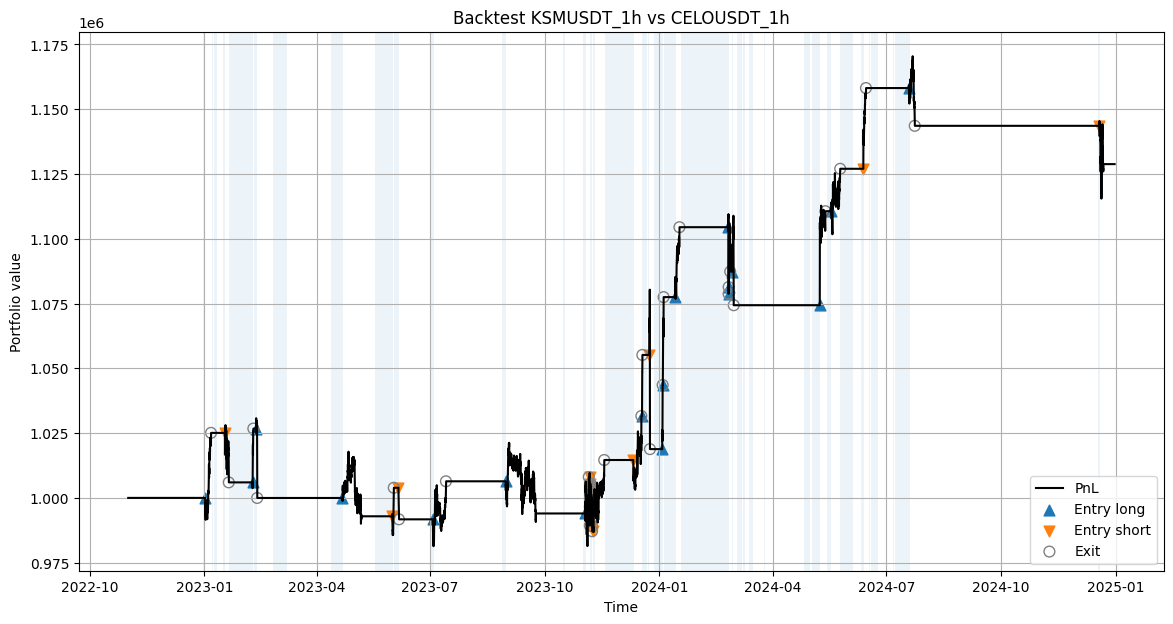

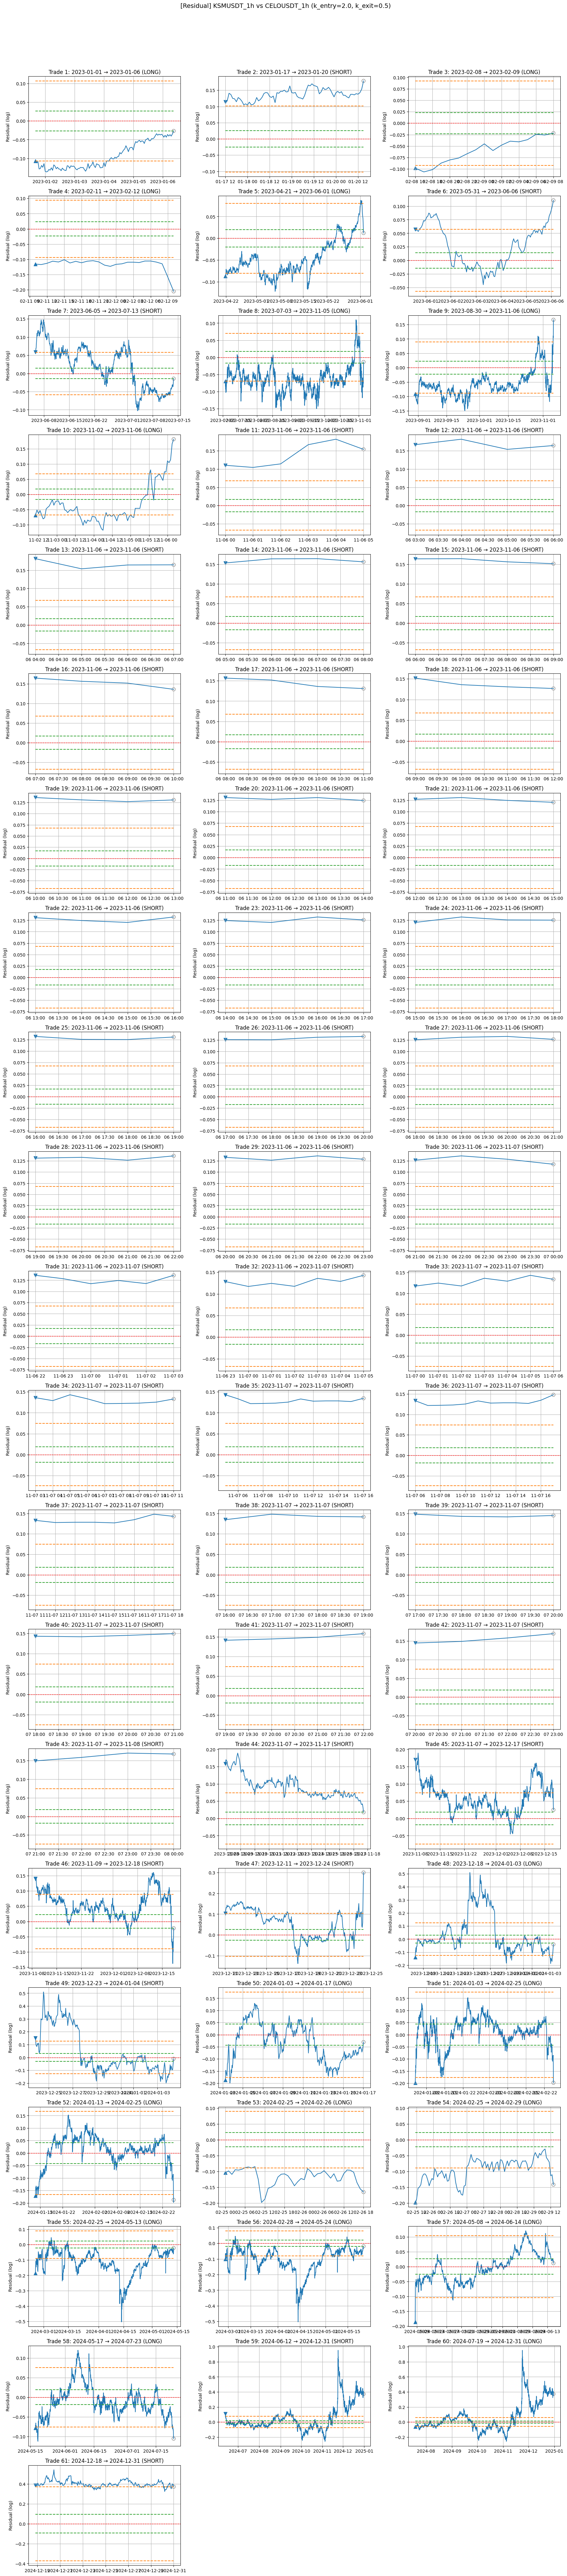

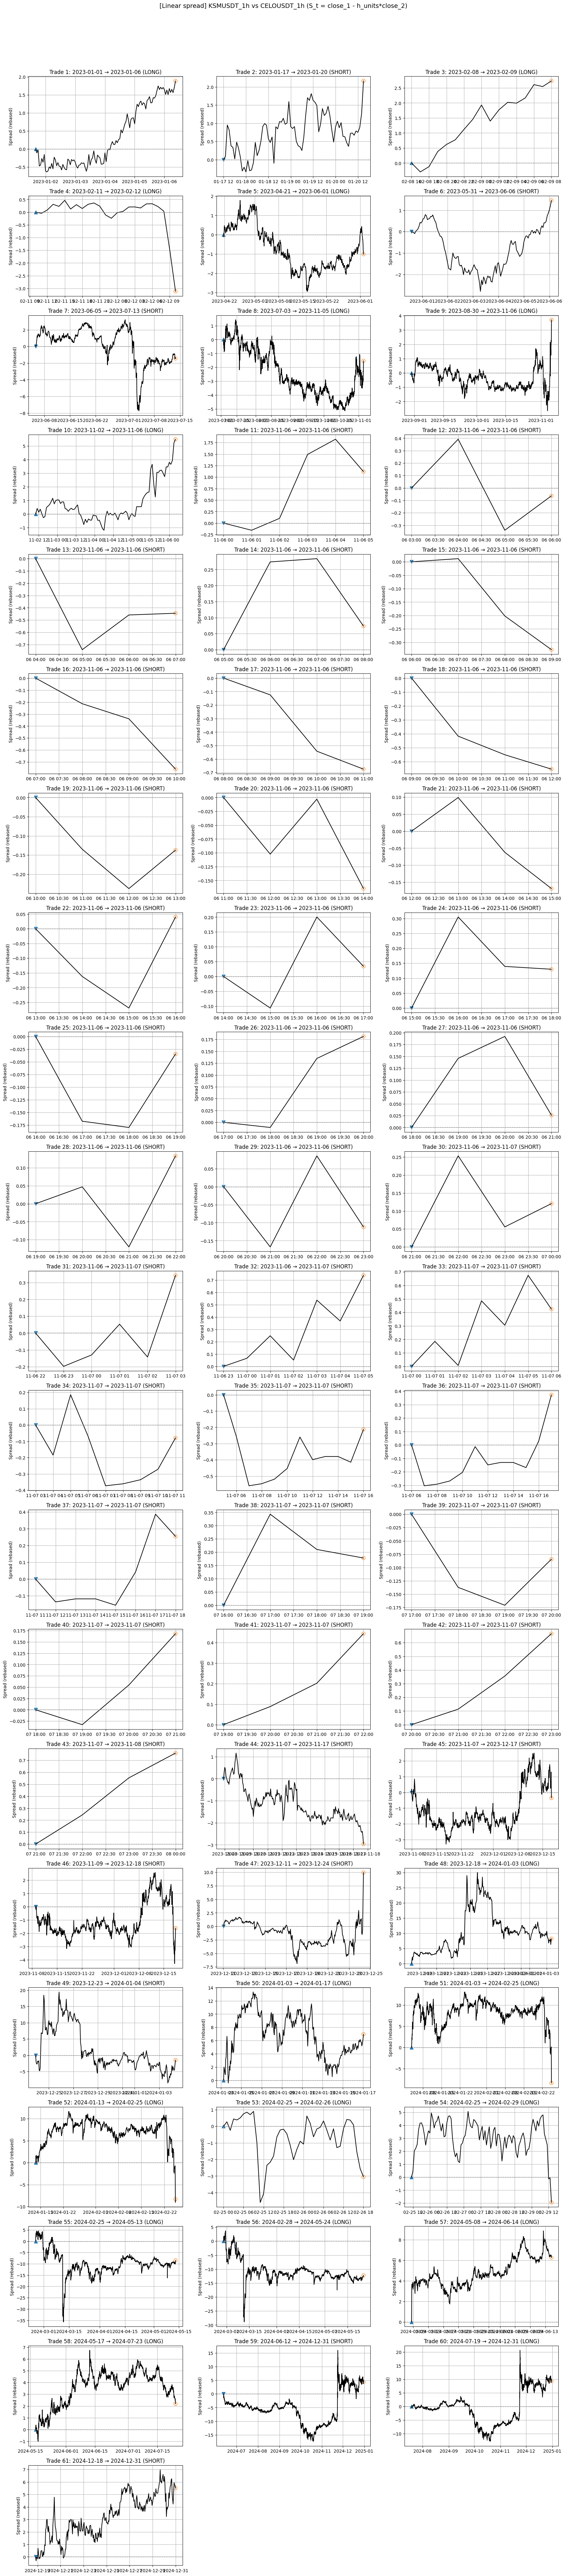

In [5]:
plot_equity_with_trades(daily, title=f"Backtest {key1} vs {key2}")

plot_trade_residual_paths(
    daily,
    entry_k=bt.entry_k,
    exit_k=bt.exit_k,
    max_trades=None,
    title_prefix=f"[Residual] {key1} vs {key2}",
)

plot_trade_linear_spread_paths(
    daily,
    prices_df=merged_df[["open_time", "close_1", "close_2"]],
    max_trades=None,
    title_prefix=f"[Linear spread] {key1} vs {key2}",
)

In [6]:
core_metrics, daily_aug = summarize_performance(
    daily, pnl_col="pnl", time_col="time", rf_annual=0.0
)
core_metrics

{'CAGR': 0.057540694113974,
 'AnnVol': 0.07685701095007039,
 'Sharpe': 0.7663738988035488,
 'MaxDrawdown': -0.05695525336858964,
 'MaxDD_Start': Timestamp('1970-01-01 00:00:00.000010038'),
 'MaxDD_End': Timestamp('1970-01-01 00:00:00.000010041'),
 'MaxDD_Length_Bars': 4}

In [7]:
reason_summary, trades_df = summarize_close_reasons(
    daily, pnl_col="pnl", time_col="time"
)
reason_summary, trades_df.head(10)

({'normal': {'count': 17, 'pnl': 432016.71408383525},
  'stop_loss': {'count': 44, 'pnl': -32495.62638115615},
  'no_longer_coint': {'count': 0, 'pnl': 0.0},
  'total_trades': 61,
  'total_pnl': 399521.0877026791},
    entry_idx  exit_idx          entry_time           exit_time     reason  \
 0       1480      1593 2023-01-01 16:00:00 2023-01-06 09:00:00     normal   
 1       1860      1935 2023-01-17 12:00:00 2023-01-20 15:00:00  stop_loss   
 2       2392      2408 2023-02-08 16:00:00 2023-02-09 08:00:00     normal   
 3       2458      2482 2023-02-11 10:00:00 2023-02-12 10:00:00  stop_loss   
 4       4123      5111 2023-04-21 19:00:00 2023-06-01 23:00:00     normal   
 5       5078      5210 2023-05-31 14:00:00 2023-06-06 02:00:00  stop_loss   
 6       5200      6115 2023-06-05 16:00:00 2023-07-13 19:00:00     normal   
 7       5864      8864 2023-07-03 08:00:00 2023-11-05 08:00:00     normal   
 8       7263      8883 2023-08-30 15:00:00 2023-11-06 03:00:00  stop_loss   
 9   

In [8]:
def extract_trade_segments(daily: pd.DataFrame) -> list[dict]:
    """Build trade segments from 'daily' log."""
    entries = daily.index[daily["entry_flag"]].tolist()
    exits = daily.index[daily["exit_flag"]].tolist()
    segs, xp = [], 0
    for e in entries:
        while xp < len(exits) and exits[xp] <= e:
            xp += 1
        x = exits[xp] if xp < len(exits) else (len(daily) - 1)
        segs.append(
            {
                "entry_idx": e,
                "exit_idx": x,
                "entry_time": pd.to_datetime(daily.loc[e, "time"]),
                "exit_time": pd.to_datetime(daily.loc[x, "time"]),
                "side": int(daily.loc[e, "entry_side"]),
            }
        )
        if xp < len(exits) and exits[xp] == x:
            xp += 1
    return segs


def mean_revert_table_and_summary(
    daily: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Compute per-trade durations (days) and a small summary DataFrame."""
    segs = extract_trade_segments(daily)
    if not segs:
        tbl = pd.DataFrame(columns=["entry_time", "exit_time", "side", "days"])
        summary = pd.DataFrame(
            [
                {
                    "n_trades": 0,
                    "avg_revert_days": np.nan,
                    "median_revert_days": np.nan,
                    "p25_revert_days": np.nan,
                    "p75_revert_days": np.nan,
                }
            ]
        )
        return tbl, summary

    rows = []
    for s in segs:
        days = (s["exit_time"] - s["entry_time"]).total_seconds() / 86400.0
        rows.append(
            {
                "entry_time": s["entry_time"],
                "exit_time": s["exit_time"],
                "side": s["side"],
                "days": days,
            }
        )
    tbl = pd.DataFrame(rows).sort_values("entry_time").reset_index(drop=True)

    summary = pd.DataFrame(
        [
            {
                "n_trades": len(tbl),
                "avg_revert_days": float(tbl["days"].mean()),
                "median_revert_days": float(tbl["days"].median()),
                "p25_revert_days": float(tbl["days"].quantile(0.25)),
                "p75_revert_days": float(tbl["days"].quantile(0.75)),
            }
        ]
    )

    return tbl, summary


trade_tbl, revert_summary = mean_revert_table_and_summary(daily)
display(trade_tbl.head(10))
display(revert_summary)

entry_time           exit_time  side        days
0 2023-01-01 16:00:00 2023-01-06 09:00:00     1    4.708333
1 2023-01-17 12:00:00 2023-01-20 15:00:00    -1    3.125000
2 2023-02-08 16:00:00 2023-02-09 08:00:00     1    0.666667
3 2023-02-11 10:00:00 2023-02-12 10:00:00     1    1.000000
4 2023-04-21 19:00:00 2023-06-01 23:00:00     1   41.166667
5 2023-05-31 14:00:00 2023-06-06 02:00:00    -1    5.500000
6 2023-06-05 16:00:00 2023-07-13 19:00:00    -1   38.125000
7 2023-07-03 08:00:00 2023-11-05 08:00:00     1  125.000000
8 2023-08-30 15:00:00 2023-11-06 03:00:00     1   67.500000
9 2023-11-02 10:00:00 2023-11-06 04:00:00     1    3.750000

n_trades  avg_revert_days  median_revert_days  p25_revert_days  \
0        61        19.487705            0.333333            0.125   

   p75_revert_days  
0        13.791667

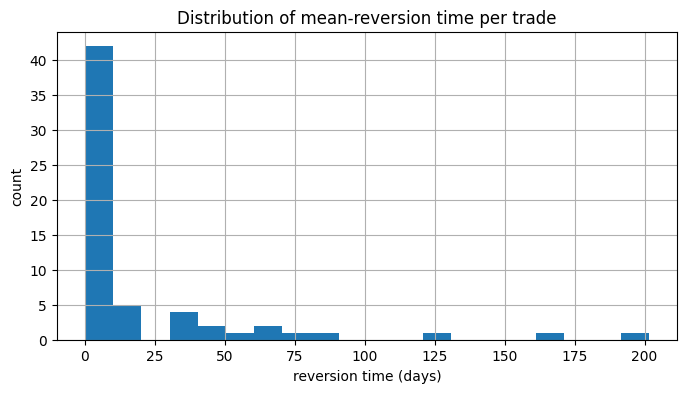

In [9]:
plt.figure(figsize=(8, 4))
plt.hist(trade_tbl["days"], bins=20)
plt.xlabel("reversion time (days)")
plt.ylabel("count")
plt.title("Distribution of mean-reversion time per trade")
plt.grid(True)
plt.show()

In [10]:

# Precompute merged_df and bars_per_day once
bars_per_day = 24
INITIAL_BAL = 1_000_000.0

start = merged_df["open_time"].min()
end = merged_df["open_time"].max()


def run_once_return_daily(
    train_len_days: int, entry_k: float, gap_bars: int = 24
) -> pd.DataFrame:
    bt = CointBacktester(
        exchange=ex,
        start_time=start,
        end_time=end,
        coint_var=coint_var,
        train_len=int(train_len_days * bars_per_day),
        gap=gap_bars,
        pval_alpha=0.05,
        entry_k=entry_k,
        exit_k=0.5,
        relaxed_pval_alpha=0.20,
        stop_k=3.5,
        initial_balance=INITIAL_BAL,
        trade_frac=0.05,
        margin_rate=0.10,
    )
    daily_i, _ = bt.run()
    return daily_i


# Grid
train_lens_days = list(range(20, 121, 20))
entry_ks = [round(x, 1) for x in np.arange(1.0, 2.5 + 1e-9, 0.5)]

grid_rows = []
for tl in tqdm(train_lens_days, desc="train_len_days"):
    for ek in tqdm(entry_ks, desc=f"entry_k (train={tl}d)", leave=False):
        daily_i = run_once_return_daily(train_len_days=tl, entry_k=ek, gap_bars=24)

        # mean reversion stats
        tbl_i, sum_i = mean_revert_table_and_summary(daily_i)

        # final equity
        final_equity = float(daily_i["pnl"].iloc[-1]) if len(daily_i) else float("nan")
        final_pnl = final_equity - INITIAL_BAL
        ret_pct = final_pnl / INITIAL_BAL if np.isfinite(final_pnl) else float("nan")

        grid_rows.append(
            {
                "train_len_days": tl,
                "entry_k": ek,
                "n_trades": int(sum_i.loc[0, "n_trades"]),
                "avg_revert_days": float(sum_i.loc[0, "avg_revert_days"]),
                "median_revert_days": float(sum_i.loc[0, "median_revert_days"]),
                "final_equity": final_equity,
                "final_pnl": final_pnl,
                "return_pct": ret_pct,
            }
        )

results_df = (
    pd.DataFrame(grid_rows)
    .sort_values(["train_len_days", "entry_k"])
    .reset_index(drop=True)
)
display(results_df)

train_len_days:   0%|          | 0/6 [00:00<?, ?it/s]

entry_k (train=20d):   0%|          | 0/4 [00:00<?, ?it/s]

entry_k (train=40d):   0%|          | 0/4 [00:00<?, ?it/s]

entry_k (train=60d):   0%|          | 0/4 [00:00<?, ?it/s]

entry_k (train=80d):   0%|          | 0/4 [00:00<?, ?it/s]

entry_k (train=100d):   0%|          | 0/4 [00:00<?, ?it/s]

entry_k (train=120d):   0%|          | 0/4 [00:00<?, ?it/s]

train_len_days  entry_k  n_trades  avg_revert_days  median_revert_days  \
0               20      1.0       140        39.978274           31.250000   
1               20      1.5        81        58.212449           52.000000   
2               20      2.0        84        47.583829           10.750000   
3               20      2.5        97        34.203179            5.250000   
4               40      1.0        94        33.890071           23.437500   
5               40      1.5        73        35.069064           18.000000   
6               40      2.0        76        21.878289            0.458333   
7               40      2.5        69         7.644324            0.083333   
8               60      1.0       108        36.695602           10.291667   
9               60      1.5        80        34.016146           10.395833   
10              60      2.0        61        19.487705            0.333333   
11              60      2.5        68         6.619485            0.041667   
12              80      1.0       100        40.549167           11.791667   
13              80      1.5        74        54.261824            8.020833   
14              80      2.0        64        50.651693            1.520833   
15              80      2.5        60        43.167361            0.208333   
16             100      1.0        70        43.593452           20.562500   
17             100      1.5        43        32.429264           12.666667   
18             100      2.0        56        29.219494            0.833333   
19             100      2.5        48        17.027778            0.083333   
20             120      1.0        68         5.077819            0.750000   
21             120      1.5        40         7.227083            1.187500   
22             120      2.0        41         3.235772            0.208333   
23             120      2.5        31         1.623656            0.041667   

    final_equity      final_pnl  return_pct  
0   1.145136e+06  145136.368069    0.145136  
1   1.123380e+06  123379.829252    0.123380  
2   1.055121e+06   55120.884641    0.055121  
3   1.002441e+06    2441.443221    0.002441  
4   8.727116e+05 -127288.356952   -0.127288  
5   9.418138e+05  -58186.247882   -0.058186  
6   9.527231e+05  -47276.886471   -0.047277  
7   9.457899e+05  -54210.139172   -0.054210  
8   9.449905e+05  -55009.513533   -0.055010  
9   1.046965e+06   46964.932132    0.046965  
10  1.128805e+06  128804.533571    0.128805  
11  1.043675e+06   43675.063883    0.043675  
12  9.593673e+05  -40632.702187   -0.040633  
13  1.029855e+06   29854.759497    0.029855  
14  9.795598e+05  -20440.164640   -0.020440  
15  1.049953e+06   49952.787312    0.049953  
16  9.589837e+05  -41016.339691   -0.041016  
17  1.004611e+06    4610.802896    0.004611  
18  9.056404e+05  -94359.647152   -0.094360  
19  1.017441e+06   17440.669640    0.017441  
20  1.311119e+06  311119.444851    0.311119  
21  1.173092e+06  173092.260915    0.173092  
22  1.149398e+06  149397.883034    0.149398  
23  9.165959e+05  -83404.088819   -0.083404

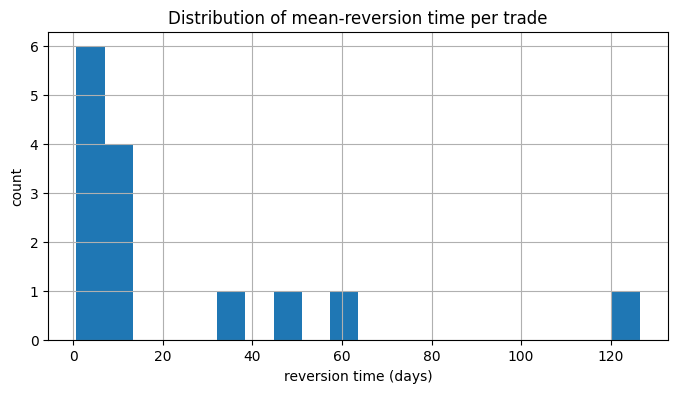

In [11]:
# %%
pivot_cnt = results_df.pivot(
    index="train_len_days", columns="entry_k", values="n_trades"
)
pivot_avg = results_df.pivot(
    index="train_len_days", columns="entry_k", values="avg_revert_days"
)
pivot_eq = results_df.pivot(
    index="train_len_days", columns="entry_k", values="final_equity"
)

display(pivot_cnt)
display(pivot_avg)
display(pivot_eq)

# Uses plot.py helpers
heatmap_from_pivot(
    pivot_cnt,
    title="Trade count",
    cbar_label="count",
    xlabel="entry_k",
    ylabel="train_len_days",
)

heatmap_from_pivot(
    pivot_avg,
    title="Avg reversion time (days)",
    cbar_label="days",
    xlabel="entry_k",
    ylabel="train_len_days",
)

heatmap_from_pivot_mask_nan(
    pivot_eq,
    title="Final equity",
    cbar_label="USD",
    xlabel="entry_k",
    ylabel="train_len_days",
)